In [37]:
import math

import numpy as np
import sklearn.gaussian_process as gp
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [9]:
def make_gp():
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    return gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [18]:
def plot_gp(x_train, y_train, x_test, y_test, std, axes=None):
    show = False
    if axes is None:
        show = True
        fig, axes = plt.subplots(2, sharex="col")
    
    # Training data
    for i in range(x_train.shape[0]):
        axes[0].scatter(x_train[i], y_train[i], color="blue", s=1)
    
    # Trained GP
    pred = y_test.reshape(x_test.shape)
    confidence_interval = 1.96 * std
    for i in range(x_train.shape[0]):
        axes[1].scatter(x_train[i], y_train[i], color="gray", alpha=0.1, s=1)
    axes[1].plot(x_test, pred)
    axes[1].fill_between(x_test, pred - confidence_interval, pred + confidence_interval, color="lightblue")
    if show:
        plt.show()

### 1. Sine function, regularly sampled, additive Gaussian measurement noise

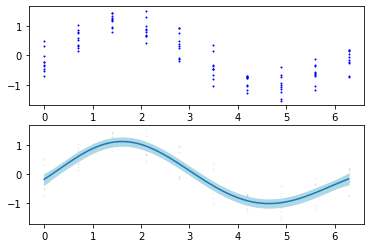

In [36]:
num_measurements = 10
num_samples = 10
x_train = np.linspace(0, 2 * math.pi, num_samples)
xs = np.array([x_train for _ in range(num_measurements)])
ys = np.array([np.sin(x_train) + np.random.normal(0, 0.3, len(x_train)) for _ in range(num_measurements)])

model = make_gp()
model.fit(xs.reshape((-1, 1)), ys.reshape((-1, 1)))
x_test = np.linspace(0, 2 * math.pi, 100)
y_pred, std = model.predict(x_test.reshape(-1, 1), return_std=True)
plot_gp(xs, ys, x_test, y_pred, std)

### 2. Sine function, randomly sampled, additive Gaussian measurement noise

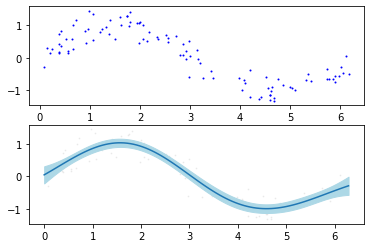

In [35]:
num_measurements = 10
num_samples = 10
x_train = np.random.uniform(0, 2 * math.pi, (num_measurements, num_samples))
ys = np.sin(x_train) + np.random.normal(0, 0.3, x_train.shape)

model = make_gp()
model.fit(x_train.reshape((-1, 1)), ys.reshape((-1, 1)))
x_test = np.linspace(0, 2 * math.pi, 100)
y_pred, std = model.predict(x_test.reshape(-1, 1), return_std=True)
plot_gp(x_train, ys, x_test, y_pred, std)

### 3. Sine function, randomly sampled, additive white measurement noise

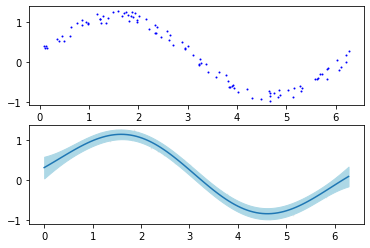

In [34]:
num_measurements = 10
num_samples = 10
x_train = np.random.uniform(0, 2 * math.pi, (num_measurements, num_samples))
ys = np.sin(x_train) + np.random.uniform(0, 0.3, x_train.shape)

model = make_gp()
model.fit(x_train.reshape((-1, 1)), ys.reshape((-1, 1)))
x_test = np.linspace(0, 2 * math.pi, 100)
y_pred, std = model.predict(x_test.reshape(-1, 1), return_std=True)
plot_gp(x_train, ys, x_test, y_pred, std)

### 4. Multiple frequencies, comparison of sampling intervals

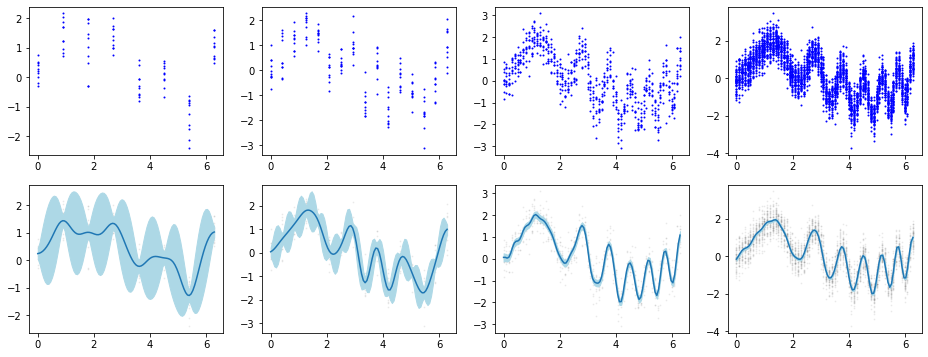

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

def run_experiment(num_measurements, num_samples, axes):
    x_train = np.array([np.linspace(0, 2 * math.pi, num_samples) for _ in range(num_measurements)])
    ys = np.sin(x_train) + np.sin(x_train ** 2) + np.random.normal(0, 0.5, x_train.shape)

    model = make_gp()
    model.fit(x_train.reshape((-1, 1)), ys.reshape((-1, 1)))
    x_test = np.linspace(0, 2 * math.pi, 100)
    y_pred, std = model.predict(x_test.reshape(-1, 1), return_std=True)
    plot_gp(x_train, ys, x_test, y_pred, std, axes)

run_experiment(10, 8, axes[:,0])
run_experiment(10, 16, axes[:,1])
run_experiment(10, 64, axes[:,2])
run_experiment(50, 64, axes[:,3])


The first two datasets violate the sampling theorem.
The third dataset does not violate the sampling theorem but overfits (too few measurements).

### 5. Prediction of future without prior

In [1]:
from timeseries_data import *

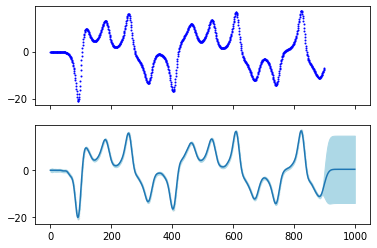

In [22]:
lorentz_data = lorentz(1000)

model = make_gp()
model.fit(np.array(range(0, 900, 10)).reshape(-1, 1), lorentz_data_1[:900:10,0].reshape(-1, 1))
y_pred, std = model.predict(np.array(range(1000)).reshape(-1, 1), return_std=True)
plot_gp(np.array(range(900)), lorentz_data_1[:900,0], np.array(range(1000)), y_pred, std)

Predicting the future without prior information for a chaotic function yields the mean.

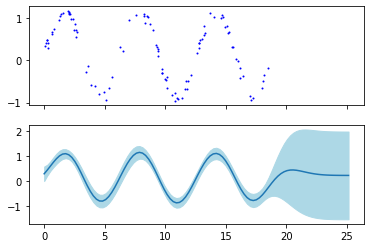

In [21]:
num_measurements = 10
num_samples = 10
x_train = np.random.uniform(0, 6 * math.pi, (num_measurements, num_samples))
ys = np.sin(x_train) + np.random.uniform(0, 0.3, x_train.shape)

model = make_gp()
model.fit(x_train.reshape((-1, 1)), ys.reshape((-1, 1)))
x_test = np.linspace(0, 8 * math.pi, 100)
y_pred, std = model.predict(x_test.reshape(-1, 1), return_std=True)
plot_gp(x_train, ys, x_test, y_pred, std)

Predicting the future without prior information for a periodic function slightly better than the mean.

### 6. Time shifts (measurement noise in time dimension)

[]

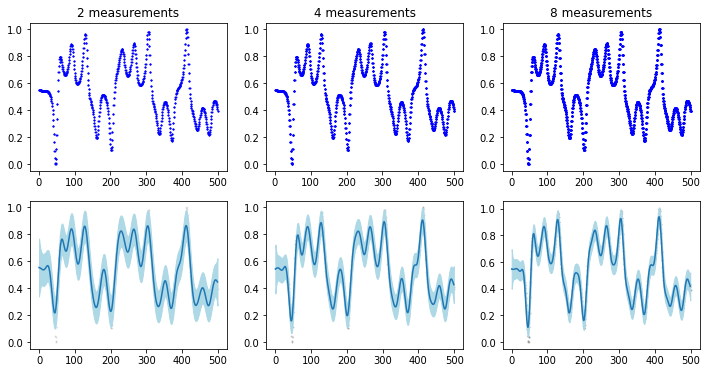

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

lorentz_data = lorentz(1000)[::2, 0]
num_samples = lorentz_data.shape[0]

scaler = MinMaxScaler()
lorentz_data = scaler.fit_transform(lorentz_data.reshape(-1, 1))

def run_experiment(num_measurements, axes):
    xs = np.array([range(num_samples) for _ in range(num_measurements)]) + np.random.uniform(0, 2, (num_measurements, num_samples))
    ys = np.array([lorentz_data for _ in range(num_measurements)])

    model = make_gp()
    model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
    y_pred, std = model.predict(np.array(range(num_samples)).reshape(-1, 1), return_std=True)
    plot_gp(xs, ys, np.array(range(num_samples)), y_pred, std, axes)
    
run_experiment(2, axes[:,0])
axes[0,0].set_title("2 measurements")
run_experiment(4, axes[:,1])
axes[0,1].set_title("4 measurements")
run_experiment(8, axes[:,2])
axes[0,2].set_title("8 measurements")
plt.plot()

Timing noise impacts regression quality simlilar to additive noise. Again, the more measurements are taken, the more confident and precise the forecast is, particularly for peaks.